# Clasficación

## Preparación de ambiente

### Carga de librerías

In [1]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from datetime import date, datetime
#from pandarallel import pandarallel
from dateutil.relativedelta import relativedelta as rd
from funpymodeling.exploratory import status

# Preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Modelado
import keras
import sklearn
from keras import metrics, Input
from keras.models import Sequential, Model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.feature_selection import VarianceThreshold
from keras.layers import Embedding, Dense, Flatten, Dropout
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split

# Visualización
import cufflinks as cf
from sklearn import set_config

# Configuración de ambiente
cf.go_offline()
set_config(display='diagram')
pd.set_option('display.max_columns', 50)
#pandarallel.initialize(progress_bar=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Funciones relevantes

In [2]:
def semiverseno(lat1, lon1, lat2, lon2):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    try:
        R = 6371.0088 # Radio de la tierra
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
        c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
        d = R * c
        return float(round(d,4))
    except:
        return 0.0

In [3]:
def make_embedding(X, X_v, feature, target, embedding_size=3):
    print(f"Creating embedding for {feature}\n")
    le = LabelEncoder()
    X_feat = le.fit_transform(X[feature])
    model = Sequential()
    model.add(Embedding(input_dim = len(le.classes_), output_dim = embedding_size, input_length = 1, name="embedding"))
    model.add(Flatten())
    model.add(Dense(20, activation="relu"))
    model.add(Dense(10, activation="tanh"))
    model.add(Dense(1, activation="softmax"))
    kmetrics = [
        metrics.Accuracy(name="accuracy"),
        metrics.AUC(name="roc")
    ]   
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=[kmetrics])
    model.fit(x = X_feat, y=X[target].to_numpy() , epochs = 25, batch_size = 6000)
    layer = model.get_layer('embedding')
    output_embeddings = layer.get_weights()
    X_emb = pd.DataFrame(output_embeddings[0], columns=[f"{feature}_embedding_{x}" for x in range(embedding_size)])
    X_emb.reset_index(drop=False, inplace=True)
    X_emb[feature] = X_emb["index"].map(lambda x: le.inverse_transform([x])[0])
    X = X.merge(X_emb, on = feature, how="inner").drop(columns=[feature, "index"])
    X_v = X_v.merge(X_emb, on = feature, how="left").drop(columns=[feature, "index"])
    return X, X_v, X_emb

In [4]:
def make_autoencoder(X_train, encoding_dim=16, batch_size=500, epochs=20):
    kmetrics = [
        metrics.RootMeanSquaredError(name='rms'),
        metrics.MeanAbsoluteError(name='mae')
    ]   
    len_input_output = X_train.shape[-1]
    input_ = Input(shape=(len_input_output,))
    encoded = Dense(units=encoding_dim*2, activation="relu")(input_)
    bottleneck = Dense(units=encoding_dim, 
                       activation="relu")(encoded)
    decoded = Dense(units=encoding_dim*2, 
                    activation="relu")(bottleneck)
    output = Dense(units=len_input_output, 
                    activation="linear")(decoded)
    autoencoder = Model(inputs=input_, outputs=output)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',
                        metrics=[kmetrics])
    autoencoder.fit(X_train, X_train,
                    batch_size=batch_size,
                    epochs=epochs)
    encoder = Model(inputs=input_, outputs=bottleneck)
    return autoencoder, encoder

In [5]:
def classification_metrics(X, y, pipe, model):
    pipe = Pipeline(pipe.steps + [("model", model)])
    ls_scores_roc = cross_val_score(estimator=pipe, X=X, y=y, scoring="roc_auc", n_jobs=-1, cv=4)
    print(f"ROC media: {np.mean(ls_scores_roc):,.2f}, desviación estándar: {np.std(ls_scores_roc)}")
    return np.mean(ls_scores_roc)

In [6]:
def hyperparam_logistic(X, y, pipe, model, param_grid):
    pipe = Pipeline(pipe.steps + [("model", model)])
    hp = RandomizedSearchCV(cv=4, 
                            param_distributions=param_grid,
                            n_iter=5,
                            scoring="roc_auc", 
                            verbose=10,
                            error_score=-1000, 
                            estimator=pipe, 
                            n_jobs=-1,
                            random_state=0)
    hp.fit(X=X, y = y)
    print(f"ROC: {hp.best_score_:,.2f}")
    return hp

## Data Wrangling

### Lectura de datos

In [7]:
df_t = pd.read_csv("./train_default.csv",sep='|').rename(columns={'PAY_0':'PAY_1'})
df_v = pd.read_csv("./val_default.csv",sep='|').rename(columns={'PAY_0':'PAY_1'})

In [8]:
print(df_t.shape)
df_t.head()

(11250, 25)


,CUSTOMER_ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,22949,30000.0000,2,2,1,25,0,0,0,0,0,0,28848.0000,27932.0000,27474.0000,28351.0000,26389.0000,26992.0000,2000.0000,1524.0000,1401.0000,917.0000,1000.0000,2000.0000,0
1,29123,160000.0000,2,2,2,39,0,0,0,0,0,0,163058.0000,161485.0000,161076.0000,156478.0000,122441.0000,120574.0000,6001.0000,6401.0000,6384.0000,4600.0000,4800.0000,4400.0000,0
2,4965,200000.0000,2,1,2,31,-2,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
3,9161,30000.0000,2,3,1,47,1,2,2,2,0,0,13012.0000,13502.0000,13892.0000,14369.0000,15333.0000,16289.0000,1000.0000,900.0000,1000.0000,1200.0000,1200.0000,1200.0000,0
4,13686,50000.0000,1,1,2,28,0,0,0,0,0,0,28639.0000,29482.0000,30455.0000,28955.0000,25959.0000,26144.0000,2100.0000,2000.0000,1000.0000,600.0000,3000.0000,0.0000,0


In [9]:
status(df_t)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,CUSTOMER_ID,0,0.0000,0,0.0000,11250,int64
1,LIMIT_BAL,0,0.0000,0,0.0000,75,float64
2,SEX,0,0.0000,0,0.0000,2,int64
3,EDUCATION,0,0.0000,4,0.0004,7,int64
4,MARRIAGE,0,0.0000,22,0.0020,4,int64
5,AGE,0,0.0000,0,0.0000,54,int64
6,PAY_1,0,0.0000,5577,0.4957,11,int64
7,PAY_2,0,0.0000,5924,0.5266,11,int64
8,PAY_3,0,0.0000,5985,0.5320,11,int64
9,PAY_4,0,0.0000,6198,0.5509,11,int64


* Todos los datos son númericos
* No hay ningún dato faltante

### Selección de variables

In [10]:
ls_pay = [f"PAY_{x}" for x in range(1,7)]
ls_bill_amt = [f"BILL_AMT{x}" for x in range(1,7)]
ls_pay_amt = [f"PAY_AMT{x}" for x in range(1,7)]

ls_features = ["CUSTOMER_ID","LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE","default.payment.next.month"]\
                + ls_pay\
                + ls_bill_amt\
                + ls_pay_amt

ls_id = ["CUSTOMER_ID"]
ls_cont = ["LIMIT_BAL"]+ls_bill_amt+ls_pay_amt
ls_disc = ["SEX","EDUCATION","MARRIAGE","AGE"]+ls_pay
target = ["default.payment.next.month"]
len(ls_features),len(ls_id+ls_cont+ls_disc+target)

(25, 25)

### Consistencia

In [11]:
for v in ls_disc:

    print(v, np.unique(df_t[v]))

SEX [1 2]
EDUCATION [0 1 2 3 4 5 6]
MARRIAGE [0 1 2 3]
AGE [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 70 72 73 74 75]
PAY_1 [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_2 [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_3 [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_4 [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_5 [-2 -1  0  2  3  4  5  6  7  8]
PAY_6 [-2 -1  0  2  3  4  5  6  7  8]


In [12]:
df_v.iloc[2891][ls_disc]

SEX          1.0000
EDUCATION    1.0000
MARRIAGE     1.0000
AGE         79.0000
PAY_1        0.0000
PAY_2        0.0000
PAY_3        0.0000
PAY_4        0.0000
PAY_5        0.0000
PAY_6        0.0000
Name: 2891, dtype: float64

In [13]:
#ajustando para el dataset de validate
df_v.at[2891, 'AGE']=75

In [14]:
    df_t[v] = df_t[v].astype("category")
    df_v[v] = df_v[v].astype("category")

In [15]:
for v in ls_cont:
    print(v)
    display(df_t[v].describe())

LIMIT_BAL


count    11250.0000
mean    166557.3333
std     129003.9130
min      10000.0000
25%      50000.0000
50%     140000.0000
75%     240000.0000
max     800000.0000
Name: LIMIT_BAL, dtype: float64

BILL_AMT1


count     11250.0000
mean      51402.0831
std       74351.6989
min     -154973.0000
25%        3507.0000
50%       22385.5000
75%       66456.0000
max      746814.0000
Name: BILL_AMT1, dtype: float64

BILL_AMT2


count    11250.0000
mean     49402.8988
std      71601.9295
min     -67526.0000
25%       3096.2500
50%      21410.5000
75%      64126.2500
max     671563.0000
Name: BILL_AMT2, dtype: float64

BILL_AMT3


count     11250.0000
mean      47221.2752
std       69307.4361
min     -157264.0000
25%        2761.2500
50%       20251.5000
75%       60394.5000
max      693131.0000
Name: BILL_AMT3, dtype: float64

BILL_AMT4


count     11250.0000
mean      43338.9047
std       64781.5721
min     -170000.0000
25%        2392.7500
50%       19128.5000
75%       54162.2500
max      706864.0000
Name: BILL_AMT4, dtype: float64

BILL_AMT5


count    11250.0000
mean     40308.9446
std      61074.1184
min     -61372.0000
25%       1900.0000
50%      18294.5000
75%      50287.7500
max     823540.0000
Name: BILL_AMT5, dtype: float64

BILL_AMT6


count     11250.0000
mean      38570.0764
std       58761.2165
min     -209051.0000
25%        1252.2500
50%       17004.0000
75%       49103.2500
max      513798.0000
Name: BILL_AMT6, dtype: float64

PAY_AMT1


count    11250.0000
mean      5691.5708
std      17729.1929
min          0.0000
25%       1000.0000
50%       2100.0000
75%       5000.0000
max     873552.0000
Name: PAY_AMT1, dtype: float64

PAY_AMT2


count     11250.0000
mean       5988.2764
std       24087.2681
min           0.0000
25%         922.0000
50%        2011.5000
75%        5000.0000
max     1227082.0000
Name: PAY_AMT2, dtype: float64

PAY_AMT3


count    11250.0000
mean      5051.6220
std      17843.7540
min          0.0000
25%        390.0000
50%       1800.0000
75%       4500.0000
max     889043.0000
Name: PAY_AMT3, dtype: float64

PAY_AMT4


count    11250.0000
mean      4834.2948
std      16397.5519
min          0.0000
25%        310.2500
50%       1500.0000
75%       4029.0000
max     621000.0000
Name: PAY_AMT4, dtype: float64

PAY_AMT5


count    11250.0000
mean      4695.2552
std      14635.8390
min          0.0000
25%        272.5000
50%       1500.0000
75%       4000.0000
max     417990.0000
Name: PAY_AMT5, dtype: float64

PAY_AMT6


count    11250.0000
mean      5095.4681
std      18148.3883
min          0.0000
25%        100.0000
50%       1500.0000
75%       4000.0000
max     527143.0000
Name: PAY_AMT6, dtype: float64

<AxesSubplot:>

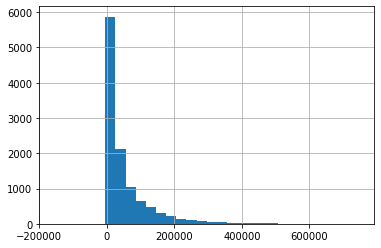

In [16]:
df_t["BILL_AMT1"].hist(bins=30)

In [17]:
#porcentaje de negativos en montos por pagar
for v in ls_bill_amt:
    print(v)
    display((df_t[v]>0).value_counts(1))

BILL_AMT1


True    0.9149
False   0.0851
Name: BILL_AMT1, dtype: float64

BILL_AMT2


True    0.8941
False   0.1059
Name: BILL_AMT2, dtype: float64

BILL_AMT3


True    0.8852
False   0.1148
Name: BILL_AMT3, dtype: float64

BILL_AMT4


True    0.8732
False   0.1268
Name: BILL_AMT4, dtype: float64

BILL_AMT5


True    0.8651
False   0.1349
Name: BILL_AMT5, dtype: float64

BILL_AMT6


True    0.8432
False   0.1568
Name: BILL_AMT6, dtype: float64

**Se supondrá que los valores negativos es saldo a favor**

### Ingeniería de variables

#### total continuas mensuales

In [18]:
df_t["BILL_AMT_mean"] = df_t[ls_bill_amt].mean(axis=1)
df_v["BILL_AMT_mean"] = df_v[ls_bill_amt].mean(axis=1)

df_t["PAY_AMT_mean"] = df_t[ls_pay_amt].mean(axis=1)
df_v["PAY_AMT_mean"] = df_v[ls_pay_amt].mean(axis=1)

#### diferencia entre deuda y pago realizado

In [19]:
for period in range(1,6):
    df_t[f"BILL_PAY_diff{period}"] = df_t[f"BILL_AMT{period}"] - df_t[f"PAY_AMT{period}"]
    df_v[f"BILL_PAY_diff{period}"] = df_v[f"BILL_AMT{period}"] - df_v[f"PAY_AMT{period}"]

In [20]:
df_t

,CUSTOMER_ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,BILL_AMT_mean,PAY_AMT_mean,BILL_PAY_diff1,BILL_PAY_diff2,BILL_PAY_diff3,BILL_PAY_diff4,BILL_PAY_diff5
0,22949,30000.0000,2,2,1,25,0,0,0,0,0,0,28848.0000,27932.0000,27474.0000,28351.0000,26389.0000,26992.0000,2000.0000,1524.0000,1401.0000,917.0000,1000.0000,2000.0000,0,27664.3333,1473.6667,26848.0000,26408.0000,26073.0000,27434.0000,25389.0000
1,29123,160000.0000,2,2,2,39,0,0,0,0,0,0,163058.0000,161485.0000,161076.0000,156478.0000,122441.0000,120574.0000,6001.0000,6401.0000,6384.0000,4600.0000,4800.0000,4400.0000,0,147518.6667,5431.0000,157057.0000,155084.0000,154692.0000,151878.0000,117641.0000
2,4965,200000.0000,2,1,2,31,-2,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,9161,30000.0000,2,3,1,47,1,2,2,2,0,0,13012.0000,13502.0000,13892.0000,14369.0000,15333.0000,16289.0000,1000.0000,900.0000,1000.0000,1200.0000,1200.0000,1200.0000,0,14399.5000,1083.3333,12012.0000,12602.0000,12892.0000,13169.0000,14133.0000
4,13686,50000.0000,1,1,2,28,0,0,0,0,0,0,28639.0000,29482.0000,30455.0000,28955.0000,25959.0000,26144.0000,2100.0000,2000.0000,1000.0000,600.0000,3000.0000,0.0000,0,28272.3333,1450.0000,26539.0000,27482.0000,29455.0000,28355.0000,22959.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,15475,120000.0000,2,3,1,52,0,0,0,0,0,0,117029.0000,118439.0000,118437.0000,116456.0000,116957.0000,119366.0000,5800.0000,4500.0000,4120.0000,4388.0000,4500.0000,4350.0000,0,117780.6667,4609.6667,111229.0000,113939.0000,114317.0000,112068.0000,112457.0000
11246,26286,240000.0000,1,1,2,41,1,-1,-1,0,0,-1,95.0000,2622.0000,3301.0000,3164.0000,360.0000,1737.0000,2622.0000,3301.0000,0.0000,360.0000,1737.0000,924.0000,0,1879.8333,1490.6667,-2527.0000,-679.0000,3301.0000,2804.0000,-1377.0000
11247,2720,160000.0000,2,2,1,38,-1,-1,-1,-1,-1,-1,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,0,316.0000,316.0000,0.0000,0.0000,0.0000,0.0000,0.0000
11248,3780,100000.0000,2,2,1,38,1,2,0,0,2,0,14483.0000,13961.0000,15323.0000,16268.0000,15868.0000,16448.0000,0.0000,1600.0000,1500.0000,0.0000,1000.0000,1500.0000,1,15391.8333,933.3333,14483.0000,12361.0000,13823.0000,16268.0000,14868.0000


#### diferencia entre cada mes para las contiuas

In [21]:
for period in range(1,6):
    df_t[f"BILL_AMT_diff{period}"] = df_t[f"BILL_AMT{period}"] - df_t[f"BILL_AMT{period+1}"]
    df_v[f"BILL_AMT_diff{period}"] = df_v[f"BILL_AMT{period}"] - df_v[f"BILL_AMT{period+1}"]
    
    df_t[f"PAY_AMT_diff{period}"] = df_t[f"PAY_AMT{period}"] - df_t[f"PAY_AMT{period+1}"]
    df_v[f"PAY_AMT_diff{period}"] = df_v[f"PAY_AMT{period}"] - df_v[f"PAY_AMT{period+1}"]

#### promedio de la diferencia entre cada mes

In [22]:
df_t["BILL_AMT_diff_mean"] = df_t[[f"BILL_AMT_diff{x}" for x in range(1,6)]].mean(axis=1)
df_v["BILL_AMT_diff_mean"] = df_v[[f"BILL_AMT_diff{x}" for x in range(1,6)]].mean(axis=1)

df_t["PAY_AMT_diff_mean"] = df_t[[f"PAY_AMT_diff{x}" for x in range(1,6)]].mean(axis=1)
df_v["PAY_AMT_diff_mean"] = df_v[[f"PAY_AMT_diff{x}" for x in range(1,6)]].mean(axis=1)

#### nueva deuda adquirida en el periodo n
nueva_deuda_n = deuda_n - deuna_n-1 + pago_n-1

In [23]:
for period in range(1,6):
    df_t[f"new_debt_{period}"] = df_t[f"BILL_AMT{period}"]-df_t[f"BILL_AMT{period+1}"]+df_t[f"PAY_AMT{period+1}"]
    df_v[f"new_debt_{period}"] = df_v[f"BILL_AMT{period}"]-df_v[f"BILL_AMT{period+1}"]+df_v[f"PAY_AMT{period+1}"]

#### promedio de la deuda adquirida

In [24]:
df_t["new_debt_mean"] = df_t[[f"new_debt_{x}" for x in range(1,6)]].mean(axis=1)
df_v["new_debt_mean"] = df_v[[f"new_debt_{x}" for x in range(1,6)]].mean(axis=1)

In [25]:
df_t

,CUSTOMER_ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,BILL_AMT_mean,PAY_AMT_mean,BILL_PAY_diff1,BILL_PAY_diff2,BILL_PAY_diff3,BILL_PAY_diff4,BILL_PAY_diff5,BILL_AMT_diff1,PAY_AMT_diff1,BILL_AMT_diff2,PAY_AMT_diff2,BILL_AMT_diff3,PAY_AMT_diff3,BILL_AMT_diff4,PAY_AMT_diff4,BILL_AMT_diff5,PAY_AMT_diff5,BILL_AMT_diff_mean,PAY_AMT_diff_mean,new_debt_1,new_debt_2,new_debt_3,new_debt_4,new_debt_5,new_debt_mean
0,22949,30000.0000,2,2,1,25,0,0,0,0,0,0,28848.0000,27932.0000,27474.0000,28351.0000,26389.0000,26992.0000,2000.0000,1524.0000,1401.0000,917.0000,1000.0000,2000.0000,0,27664.3333,1473.6667,26848.0000,26408.0000,26073.0000,27434.0000,25389.0000,916.0000,476.0000,458.0000,123.0000,-877.0000,484.0000,1962.0000,-83.0000,-603.0000,-1000.0000,371.2000,0.0000,2440.0000,1859.0000,40.0000,2962.0000,1397.0000,1739.6000
1,29123,160000.0000,2,2,2,39,0,0,0,0,0,0,163058.0000,161485.0000,161076.0000,156478.0000,122441.0000,120574.0000,6001.0000,6401.0000,6384.0000,4600.0000,4800.0000,4400.0000,0,147518.6667,5431.0000,157057.0000,155084.0000,154692.0000,151878.0000,117641.0000,1573.0000,-400.0000,409.0000,17.0000,4598.0000,1784.0000,34037.0000,-200.0000,1867.0000,400.0000,8496.8000,320.2000,7974.0000,6793.0000,9198.0000,38837.0000,6267.0000,13813.8000
2,4965,200000.0000,2,1,2,31,-2,-2,-2,-2,-2,-2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,9161,30000.0000,2,3,1,47,1,2,2,2,0,0,13012.0000,13502.0000,13892.0000,14369.0000,15333.0000,16289.0000,1000.0000,900.0000,1000.0000,1200.0000,1200.0000,1200.0000,0,14399.5000,1083.3333,12012.0000,12602.0000,12892.0000,13169.0000,14133.0000,-490.0000,100.0000,-390.0000,-100.0000,-477.0000,-200.0000,-964.0000,0.0000,-956.0000,0.0000,-655.4000,-40.0000,410.0000,610.0000,723.0000,236.0000,244.0000,444.6000
4,13686,50000.0000,1,1,2,28,0,0,0,0,0,0,28639.0000,29482.0000,30455.0000,28955.0000,25959.0000,26144.0000,2100.0000,2000.0000,1000.0000,600.0000,3000.0000,0.0000,0,28272.3333,1450.0000,26539.0000,27482.0000,29455.0000,28355.0000,22959.0000,-843.0000,100.0000,-973.0000,1000.0000,1500.0000,400.0000,2996.0000,-2400.0000,-185.0000,3000.0000,499.0000,420.0000,1157.0000,27.0000,2100.0000,5996.0000,-185.0000,1819.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,15475,120000.0000,2,3,1,52,0,0,0,0,0,0,117029.0000,118439.0000,118437.0000,116456.0000,116957.0000,119366.0000,5800.0000,4500.0000,4120.0000,4388.0000,4500.0000,4350.0000,0,117780.6667,4609.6667,111229.0000,113939.0000,114317.0000,112068.0000,112457.0000,-1410.0000,1300.0000,2.0000,380.0000,1981.0000,-268.0000,-501.0000,-112.0000,-2409.0000,150.0000,-467.4000,290.0000,3090.0000,4122.0000,6369.0000,3999.0000,1941.0000,3904.2000
11246,26286,240000.0000,1,1,2,41,1,-1,-1,0,0,-1,95.0000,2622.0000,3301.0000,3164.0000,360.0000,1737.0000,2622.0000,3301.0000,0.0000,360.0000,1737.0000,924.0000,0,1879.8333,1490.6667,-2527.0000,-679.0000,3301.0000,2804.0000,-1377.0000,-2527.0000,-679.0000,-679.0000,3301.0000,137.0000,-360.0000,2804.0000,-1377.0000,-1377.0000,813.0000,-328.4000,339.6000,774.0000,-679.0000,497.0000,4541.0000,-453.0000,936.0000
11247,2720,160000.0000,2,2,1,38,-1,-1,-1,-1,-1,-1,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000,0,316.0000,316.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,316.0000,316.0000,316.0000,316.0000,316.0000,316.0000
11248,3780,100000.0000,2,2,1,38,1,2,0,0,

In [26]:
set(df_t.columns)-set(df_v.columns)

{'default.payment.next.month'}

### Transformando variables categóricas

In [27]:
for v in ls_disc:
    df_t, df_v, embedding = make_embedding(df_t, df_v, v, target)

Creating embedding for SEX

Epoch 1/25
2/2 [==============================] - 9s 9ms/step - loss: 0.6943 - accuracy: 0.2218 - roc: 0.5000
Epoch 2/25
2/2 [==============================] - 0s 21ms/step - loss: 0.6885 - accuracy: 0.2214 - roc: 0.5000
Epoch 3/25
2/2 [==============================] - 0s 14ms/step - loss: 0.6829 - accuracy: 0.2196 - roc: 0.5000
Epoch 4/25
2/2 [==============================] - 0s 14ms/step - loss: 0.6776 - accuracy: 0.2218 - roc: 0.5000
Epoch 5/25
2/2 [==============================] - 0s 14ms/step - loss: 0.6724 - accuracy: 0.2224 - roc: 0.5000
Epoch 6/25
2/2 [==============================] - 0s 17ms/step - loss: 0.6671 - accuracy: 0.2219 - roc: 0.5000
Epoch 7/25
2/2 [==============================] - 0s 13ms/step - loss: 0.6616 - accuracy: 0.2220 - roc: 0.5000
Epoch 8/25
2/2 [==============================] - 0s 14ms/step - loss: 0.6560 - accuracy: 0.2219 - roc: 0.5000
Epoch 9/25
2/2 [==============================] - 0s 12ms/step - loss: 0.6503 - accur

2/2 [==============================] - 0s 12ms/step - loss: 0.5912 - accuracy: 0.2224 - roc: 0.5000
Epoch 21/25
2/2 [==============================] - 0s 11ms/step - loss: 0.5854 - accuracy: 0.2232 - roc: 0.5000
Epoch 22/25
2/2 [==============================] - 0s 12ms/step - loss: 0.5788 - accuracy: 0.2215 - roc: 0.5000
Epoch 23/25
2/2 [==============================] - 0s 14ms/step - loss: 0.5735 - accuracy: 0.2240 - roc: 0.5000
Epoch 24/25
2/2 [==============================] - 0s 13ms/step - loss: 0.5654 - accuracy: 0.2194 - roc: 0.5000
Epoch 25/25
2/2 [==============================] - 0s 13ms/step - loss: 0.5605 - accuracy: 0.2212 - roc: 0.5000
Creating embedding for PAY_3

Epoch 1/25
2/2 [==============================] - 1s 14ms/step - loss: 0.6950 - accuracy: 0.2192 - roc: 0.5000
Epoch 2/25
2/2 [==============================] - 0s 16ms/step - loss: 0.6906 - accuracy: 0.2210 - roc: 0.5000
Epoch 3/25
2/2 [==============================] - 0s 11ms/step - loss: 0.6863 - accuracy

## Modelado

### Separación de sets

In [28]:
X = df_t.drop(columns='default.payment.next.month')
y = df_t[target]

### Escalado

In [29]:
mm = MinMaxScaler()
Xs = pd.DataFrame(mm.fit_transform(X), columns=X.columns, index=X.index)
df_vs = pd.DataFrame(mm.transform(df_v), columns=df_v.columns, index=df_v.index)
Xs

,CUSTOMER_ID,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_mean,PAY_AMT_mean,BILL_PAY_diff1,BILL_PAY_diff2,BILL_PAY_diff3,BILL_PAY_diff4,BILL_PAY_diff5,BILL_AMT_diff1,PAY_AMT_diff1,BILL_AMT_diff2,PAY_AMT_diff2,...,EDUCATION_embedding_2,MARRIAGE_embedding_0,MARRIAGE_embedding_1,MARRIAGE_embedding_2,AGE_embedding_0,AGE_embedding_1,AGE_embedding_2,PAY_1_embedding_0,PAY_1_embedding_1,PAY_1_embedding_2,PAY_2_embedding_0,PAY_2_embedding_1,PAY_2_embedding_2,PAY_3_embedding_0,PAY_3_embedding_1,PAY_3_embedding_2,PAY_4_embedding_0,PAY_4_embedding_1,PAY_4_embedding_2,PAY_5_embedding_0,PAY_5_embedding_1,PAY_5_embedding_2,PAY_6_embedding_0,PAY_6_embedding_1,PAY_6_embedding_2
0,0.7650,0.0253,0.2038,0.1292,0.2172,0.2262,0.0992,0.3265,0.0023,0.0012,0.0016,0.0015,0.0024,0.0038,0.0792,0.0023,0.5209,0.6341,0.5816,0.5110,0.3137,0.4669,0.6426,0.4338,0.2595,...,1.0000,0.0199,1.0000,1.0000,0.5756,1.0000,0.7318,0.5102,0.6853,0.2137,0.0000,0.1125,1.0000,0.5891,0.5703,0.7250,0.5670,0.7787,0.5397,0.9582,0.5928,0.1791,0.3780,0.9182,0.0000
1,0.3835,0.2405,0.2918,0.2421,0.3187,0.3203,0.1943,0.4327,0.0057,0.0034,0.0043,0.0064,0.0090,0.0076,0.2130,0.0066,0.5732,0.6822,0.6370,0.5695,0.3853,0.4622,0.6429,0.4306,0.2597,...,1.0000,0.0199,1.0000,1.0000,0.5756,1.0000,0.7318,0.5102,0.6853,0.2137,0.0000,0.1125,1.0000,0.5891,0.5703,0.7250,0.5670,0.7787,0.5397,0.9582,0.5928,0.1791,0.3780,0.9182,0.0000
2,0.3387,0.1013,0.2360,0.1599,0.2385,0.2425,0.1129,0.3395,0.0023,0.0017,0.0023,0.0032,0.0048,0.0021,0.1079,0.0030,0.5408,0.6473,0.5931,0.5207,0.3235,0.4740,0.6422,0.4389,0.2594,...,1.0000,0.0199,1.0000,1.0000,0.5756,1.0000,0.7318,0.5102,0.6853,0.2137,0.0000,0.1125,1.0000,0.5891,0.5703,0.7250,0.5670,0.7787,0.5397,0.9582,0.5928,0.1791,0.3780,0.9182,0.0000
3,0.4382,0.1392,0.2061,0.1903,0.2709,0.2793,0.1561,0.3993,0.0495,0.0025,0.0032,0.0048,0.0108,0.0047,0.1451,0.0157,0.4941,0.6601,0.6108,0.5438,0.3549,0.4179,0.6773,0.4333,0.2596,...,1.0000,0.0199,1.0000,1.0000,0.5756,1.0000,0.7318,0.5102,0.6853,0.2137,0.0000,0.1125,1.0000,0.5891,0.5703,0.7250,0.5670,0.7787,0.5397,0.9582,0.5928,0.1791,0.3780,0.9182,0.0000
4,0.3431,0.1392,0.2296,0.1496,0.2243,0.2264,0.0965,0.2931,0.0018,0.0026,0.0013,0.0100,0.0000,0.0006,0.0841,0.0033,0.5372,0.6421,0.5857,0.5073,0.3125,0.4762,0.6408,0.4438,0.2608,...,1.0000,0.0199,1.0000,1.0000,0.5756,1.0000,0.7318,0.5102,0.6853,0.2137,0.0000,0.1125,1.0000,0.5891,0.5703,0.7250,0.5670,0.7787,0.5397,0.9582,0.5928,0.1791,0.3780,0.9182,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,0.0707,0.4304,0.1745,0.0946,0.1878,0.1966,0.0721,0.2925,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0380,0.0000,0.5042,0.6198,0.5660,0.4926,0.2934,0.4659,0.6422,0.4332,0.2594,...,0.4084,0.0199,1.0000,1.0000,0.4435,0.7840,0.2057,0.0000,0.0000,0.2583,0.8528,1.0000,0.2252,0.0402,0.1780,0.0671,0.0000,0.6975,0.9701,0.2344,0.7058,0.6483,0.9242,0.1284,1.0000
11246,0.5315,0.0380,0.1745,0.0946,0.1878,0.1966,0.0721,0.2925,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0380,0.0000,0.5042,0.6198,0.5660,0.4926,0.2934,0.4659,0.6422,0.4332,0.2594,...,0.9234,0.0199,1.0000,1.0000,0.7211,0.4977,0.1610,0.0000,0.0000,0.2583,0.8528,1.0000,0.2252,0.0402,0.1780,0.0671,0.0000,0.6975,0.9701,0.2344,0.7058,0.6483,0.9242,0.1284,1.0000
11247,0.2693,0.0253,0.1745,0.0946,0.1877,0.1966,0.0721,0.2925,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0380,0.0000,0.5042,0.6198,0.5660,0.4926,0.2934,0.4659,0.6422,0.4332,0.2594,...,0.9234,0.0199,1.0000,1.0000,0.7211,0.4977,0.1610,0.0000,0.0000,0.2583,0.8528,1.0000,0.2252,0.0402,0.1780,0.0671,0.0000,0.6975,0.9701,0.2344,0.7058,0.6483,0.9242,0.1284,1.0000
11248,0.6053,0.1139,0.2524,0.2138,0.2896,0.3040,0.1881,0.4324,0.0229,0.0000,0.0112,0.0161,0.0000,0.0000,0.1855,0.0106,0.5386,0.6722,0.6166,0.5546,0.3838,0.4456,0.6597,0.4349,

### Autoencoder

In [30]:
autoencoder, encoder = make_autoencoder(X_train=Xs, encoding_dim=np.round(np.sqrt(Xs.shape[1]), 0), batch_size=1500, epochs=50)

Epoch 1/50
8/8 [==============================] - 1s 3ms/step - loss: 0.2550 - rms: 0.5050 - mae: 0.4055
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.2295 - rms: 0.4791 - mae: 0.3822
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.2052 - rms: 0.4530 - mae: 0.3594
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.1783 - rms: 0.4223 - mae: 0.3333
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1506 - rms: 0.3881 - mae: 0.3034
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.1225 - rms: 0.3500 - mae: 0.2681
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0970 - rms: 0.3113 - mae: 0.2316
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0766 - rms: 0.2767 - mae: 0.2007
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0622 - rms: 0.2493 - mae: 0.1755
Epoch 10/50
8/8 [==============================] - 0s 4

In [31]:
Xe = pd.DataFrame(data=encoder.predict(Xs), index=Xs.index)
df_ve = pd.DataFrame(data=encoder.predict(df_vs), index=df_vs.index)

### Pipeline

In [32]:
pipe = Pipeline([("vt", VarianceThreshold(threshold=0.0001)), ("mm", StandardScaler())])

### Modelos

In [33]:
modelo = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight="balanced")

In [34]:
names = ["Logistic Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    LogisticRegression(max_iter=1000, n_jobs=-1, class_weight="balanced"),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [35]:
classifiers_dict = {name:{"modelo":classifier} for name, classifier in zip(names,classifiers)}

### Cross Valdation

In [36]:
for modelo in classifiers_dict:
    print(modelo)
    classifiers_dict[modelo]["ROC media"] = classification_metrics(Xs, y, pipe, classifiers_dict[modelo]["modelo"])
    print("\n")

Logistic Regression
ROC media: 0.73, desviación estándar: 0.10366517600875193


Nearest Neighbors
ROC media: 0.59, desviación estándar: 0.03549461340065103


Linear SVM
ROC media: 0.71, desviación estándar: 0.08605676073721857


RBF SVM
ROC media: 0.49, desviación estándar: 0.028053739261912267


Decision Tree
ROC media: 0.66, desviación estándar: 0.04822296971940284


Random Forest
ROC media: 0.68, desviación estándar: 0.1281491817852749


Neural Net
ROC media: 0.70, desviación estándar: 0.07114674011882834


AdaBoost
ROC media: 0.72, desviación estándar: 0.08151400543636131


Naive Bayes
ROC media: 0.71, desviación estándar: 0.10714080992564985


QDA
ROC media: 0.68, desviación estándar: 0.0834150297554993




### Hyperparametrización

#### Logistic regresion

In [37]:
model = LogisticRegression()
param_grid = {"model__penalty": ["l1", "l2"],
              "model__C": [x/100 for x in range(100)]+[0],
              "model__class_weight": ["balanced", None],
              "model__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }

In [38]:
bm = hyperparam_logistic(Xe, y, pipe, model, param_grid)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
ROC: 0.72


/home/paramont/work/envs/diplomado/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### SVM

In [39]:
model = SVC(random_state = 0,probability=True)
param_grid = {'model__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                 'model__degree':[2,3,4]}

In [40]:
svm = hyperparam_logistic(Xe, y, pipe, model, param_grid)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


/home/paramont/work/envs/diplomado/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ROC: 0.72


#### AdaBoost

In [41]:
model = AdaBoostClassifier()
param_grid = {
              'model__learning_rate': np.arange(0.1,1,.1)
             }

In [42]:
ab = hyperparam_logistic(Xe, y, pipe, model, param_grid)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


/home/paramont/work/envs/diplomado/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ROC: 0.71


### Resultados

In [43]:
proba = svm.predict_proba(Xe)[:, 1]

In [44]:
res = Xe.join(y)

In [45]:
res["proba"] = proba

In [46]:
svm.predict(Xe).max()

1

In [47]:
svm.score(Xe, y)

0.6990387571058836

In [48]:
res["y_hat"] = svm.predict(Xe)

In [49]:
res[res["y_hat"]==1].mean()

0                            1.7737
1                            0.0000
2                            0.0000
3                            0.0000
4                            0.0000
5                            0.6040
6                            2.2937
7                            0.4000
default.payment.next.month   0.6481
proba                        0.6610
y_hat                        1.0000
dtype: float64

In [50]:
res["proba"].iplot(kind="histogram", theme="solar")

### Transformando el dataset de validación

In [51]:
resultados = pd.DataFrame()
resultados["CUSTOMER_ID"] = df_v["CUSTOMER_ID"]
resultados["y_hat"] = svm.predict(df_ve)

In [52]:
resultados.to_csv("HernandezGonzalezRicardoParamont_DefaultPayment.csv",index=False)

In [57]:
df_v2 = pd.read_csv("./val_default.csv",sep='|').rename(columns={'PAY_0':'PAY_1'})

In [60]:
(resultados["CUSTOMER_ID"] == df_v2["CUSTOMER_ID"]).any()

True

In [62]:
resultados["y_hat"]

0       0
1       0
2       0
3       0
4       0
       ..
3745    0
3746    0
3747    0
3748    0
3749    1
Name: y_hat, Length: 3750, dtype: int64